# Deep learning
---------------------------

This example shows how to use ATOM to train and validate a Convolutional Neural Network implemented with [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset whose goal is to classify handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(
        Conv2D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=10, activation="softmax"))
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym="NN", fullname="Neural network")

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

data = (X_train, y_train), (X_test, y_test)

## Run the pipeline

In [5]:
atom = ATOMClassifier(*data, n_rows=0.1, n_jobs=6, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 6 cores.

Dataset stats ==================== >>
Shape: (7000, (28, 28, 1), 2)
-------------------------------------
Train set size: 6000
Test set size: 1000
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   693 (1.1) |   587 (1.1) |   106 (1.4) |
| 1  |   830 (1.4) |   705 (1.3) |   125 (1.6) |
| 2  |   697 (1.1) |   591 (1.1) |   106 (1.4) |
| 3  |   725 (1.2) |   636 (1.2) |    89 (1.2) |
| 4  |   665 (1.1) |   565 (1.1) |   100 (1.3) |
| 5  |   607 (1.0) |   530 (1.0) |    77 (1.0) |
| 6  |   681 (1.1) |   592 (1.1) |    89 (1.2) |
| 7  |   719 (1.2) |   613 (1.2) |   106 (1.4) |
| 8  |   675 (1.1) |   584 (1.1) |    91 (1.2) |
| 9  |   708 (1.2) |   597 (1.1) |   111 (1.4) |



In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
atom.head()

,Multidimensional feature,Target
0,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",0
1,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",7
2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",5
3,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",5
4,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",3


In [7]:
# Every row in the column contains the data of one image
print(f"Shape of one image: {atom.iloc[0, 0].shape}")
print(f"atom's shape (n_rows, (shape_image), n_cols): {atom.shape}")

Shape of one image: (28, 28, 1)
atom's shape (n_rows, (shape_image), n_cols): (7000, (28, 28, 1), 2)


In [8]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ========================= >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
| call             | f1_weighted | best_f1_weighted |    time | total_time |
| ---------------- | ----------- | ---------------- | ------- | ---------- |
| Initial point 1  |      0.9474 |           0.9474 | 22.212s |    22.216s |
| Initial point 2  |      0.9538 |           0.9538 |  9.921s |    32.309s |
| Initial point 3  |      0.9316 |           0.9538 |  8.794s |    41.147s |
| Initial point 4  |        0.96 |             0.96 |  9.248s |    50.439s |
| Initial point 5  |      0.9538 |             0.96 |  0.001s |    50.483s |

Results for Neural network:         
Bayesian Optimization ---------------------------
Best call --> Initial point 4
Best parameters --> {'epochs': 2, 'batch_size': 128}
Best evaluation --> f1_weighted: 0.96
Time elapsed: 52.270s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.9978
Test evaluation --> f1_weighted: 0

## Analyze the results

In [9]:
# Use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[2.7217180e-08, 3.7889632e-07, 2.1415239e-07, ..., 5.2748578e-07,
        4.6841746e-05, 7.1230751e-08],
       [9.9992752e-01, 3.0457694e-09, 8.4352505e-06, ..., 5.4020823e-08,
        1.0949227e-06, 8.3069299e-06],
       [4.3855995e-11, 2.2476294e-09, 1.8426000e-06, ..., 5.5313777e-08,
        6.9489611e-06, 2.2116525e-05],
       ...,
       [5.4082353e-11, 1.3199553e-09, 1.9001129e-12, ..., 1.0628378e-12,
        1.3753484e-05, 3.6109478e-09],
       [9.7216565e-05, 9.0953538e-09, 2.5953196e-07, ..., 2.6565110e-07,
        1.4668365e-09, 1.2797149e-09],
       [5.0796825e-05, 1.6605163e-05, 7.0580322e-04, ..., 8.1940605e-05,
        9.9320203e-01, 5.4975953e-03]], dtype=float32)

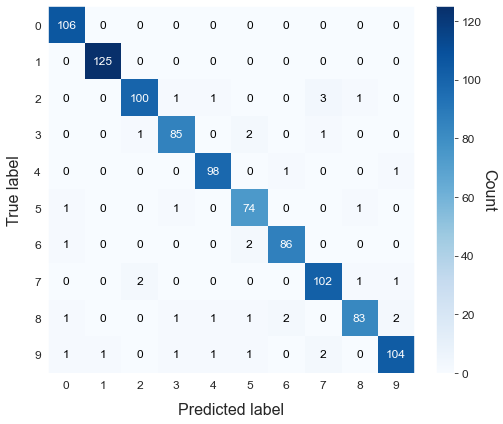

In [10]:
# Or make plots...
atom.nn.plot_confusion_matrix()